##Motivation for Session:
 
 What ML model should I use for given Problem?
 
 Too Many Parameters exists to tune, when and where do we tune these so called hyper parameters?
 
 How do we interact with Data and Analyze?
 
 Nobody can tell answer based on intutions...Happy Experimenting....

##1) Loading All Necessary packages:






In [0]:
## Loading Basic Packages

from __future__ import print_function                #To ensure that future statements run under releases prior to 3 at least yield runtime exceptions

import logging                                       #defines functions and classes which implement a flexible event logging system for applications and libraries.
import numpy as np                                   #fundamental package for scientific computing with Python
from optparse import OptionParser                     #(earlier version of python, now depreceated)
#from argparse import ArgumentParser                  # Parser for command-line options, arguments and sub-commands
import sys                                           #System-specific parameters and functions
from time import time                                #Time access and conversions
import matplotlib.pyplot as plt                      # plots and visualizations
import pandas as pd                                  # Data Analysis Library
from numpy import random                             # pseudo-random number generators for various distributions

## Loading packages for Pre-processing
import gensim                                       # Analyze plain-text documents for semantic structure
import nltk                                         # library to play with natural language
from nltk.corpus import stopwords                   # Common words not useful for building model
import re                                           #  provides regular expression matching operations
from bs4 import BeautifulSoup                       #  Python library for pulling data out of HTML and XML files

## Loading Dataset (In general, CSV or Sql file must be loaded)
from sklearn.datasets import fetch_20newsgroups                          # To avoid Headache of Uploading in colab, working on scikit learn available dataset

## Feature Extraction and selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer  # Bag of words, tfidf vect, hashing for large corpus
from sklearn.feature_selection import SelectFromModel
#from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA               # Dimensionality Reduction

## For comupting Pdfs
from sklearn.utils.extmath import density            # Compute density of a sparse vector

## Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

## Transforms and fitting
from sklearn.pipeline import Pipeline               # implement fit and transform methods

## Classifiers (Few picked for evaluation)
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
#from sklearn.linear_model import Perceptron
#from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

##2) Exploring Data 

In [0]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')
  
  

In [0]:
# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



In [0]:
# #############################################################################
# Load some categories from the training set
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories



In [0]:
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Extracting features from the training data using a sparse vectorizer
done in 0.572451s at 6.952MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.339298s at 8.451MB/s
n_samples: 1353, n_features: 33809



Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.283s
test time:  0.003s
accuracy:   0.897
dimensionality: 33809
density: 1.000000


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
train time: 0.003s
test time:  0.250s
accuracy:   0.858

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurit

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


train time: 0.313s
test time:  0.002s
accuracy:   0.873
dimensionality: 33809
density: 0.005568


________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.505s
test time:  0.002s
accuracy:   0.884
dimensionality: 33809
density: 0.020505


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_it

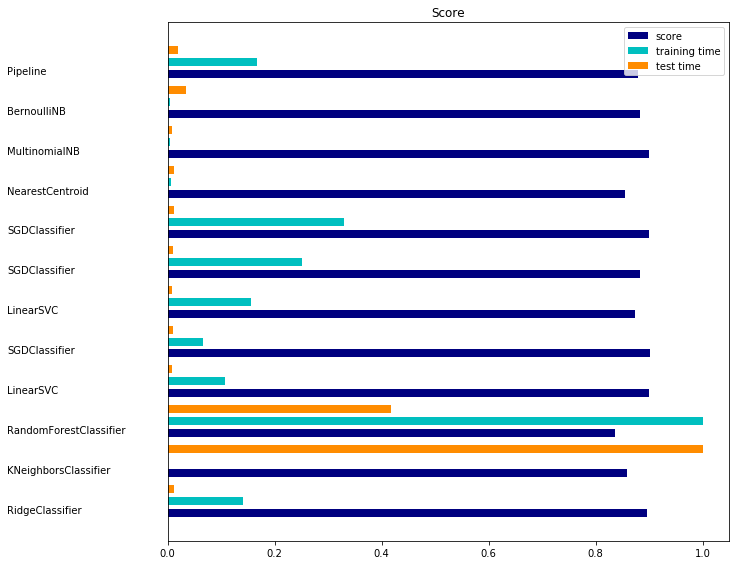

In [0]:
# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        #(Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        #(PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         #"Passive-Aggressive"),#
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
#results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()


[2 1 1 ... 3 1 1]
[2 1 1 ... 3 1 1]
Confusion matrix, without normalization
[[266   9   7  37]
 [  1 381   4   3]
 [  0  23 371   0]
 [ 40  10   6 195]]
Normalized confusion matrix
[[0.83 0.03 0.02 0.12]
 [0.   0.98 0.01 0.01]
 [0.   0.06 0.94 0.  ]
 [0.16 0.04 0.02 0.78]]


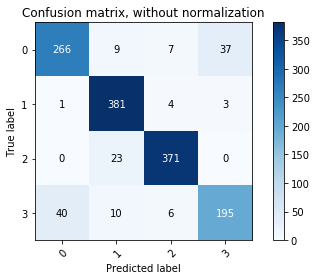

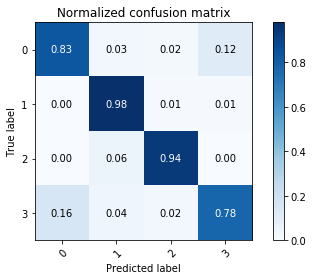

In [0]:
# Confusion matrix
from sklearn.utils.multiclass import unique_labels

#class_names = target_names

clf1 = RidgeClassifier(tol=1e-2, solver="sag")
#opts.print_cm
y_pred = clf1.fit(X_train, y_train).predict(X_test)

print(y_test)
print (y_pred)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels((y_true), (y_pred))]
    classes = list(unique_labels(y_true, y_pred))
    #classes = classes[unique_labels(y_test, pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.90      0.98      0.94       389
         sci.space       0.96      0.94      0.95       394
talk.religion.misc       0.83      0.78      0.80       251

         micro avg       0.90      0.90      0.90      1353
         macro avg       0.89      0.88      0.88      1353
      weighted avg       0.90      0.90      0.90      1353



References:

https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb

https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb

https://datascience.stackexchange.com/questions/20076/word2vec-vs-sentence2vec-vs-doc2vec

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

For details about parameter estimation using cross validation:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

To plot ROC_AUC curves with cross vaidation:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
